# Overview

This notebook provides some of the calculations I used to figure out how
to trade off the positive and negative effects of Dying Sun and AoE on the
tree like the Amplify node.  This was done in service of my BLS Berserker
Molten Strike build guide
(https://www.pathofexile.com/forum/view-thread/1882710).

If you prefer a simpler online spreadsheet, see this Google Sheet:
https://docs.google.com/spreadsheets/d/1V-WLgY5KQLBOHwMdLrBs4Z04y3W7PL5cWnHEmlHhfbs/edit?usp=sharing
To the best of our knowledge, it does accurate single-target
calculations on namelocked mobs.  Under the current model, it is
more accurate than this notebook.

This notebook is targeted at people who want to understand the gory details
of how Molten Strike's mechanics interact with each other.  We use concepts
and tools from multivariate calculus and signal processing here.

## Conclusion 1: Dying Sun + 2x Wildfires Will Double Your Projectile DPS

Dying Sun and Wildfire jewels

 * each add 2 extra projectiles (very good),
 * increase the splash area of balls (good), but
 * spread the projectiles away from single targets (bad), and
 * lower the average point blank bonus (bad).
 
It turns out that the benefits of the flask and jewels significantly
outweigh the downsides against bosses.  Assuming the following,

 * we're hitting a mid-sized boss with radius 3,
 * we ignore the melee hit,
 * no Dying Sun,
 * +3 projectile helm enchant,
 * concentrated effect (helps damage per hit and increases hit rate), 
 * no AoE on the tree (AoE would hurt our hit rate), 
 * point blank (adds a lot of damage, but increases the penalties for having AoE), and
 * a name-locked boss,

2x Wildfires add 68% more DPS, ignoring the increased fire damage
on the jewels.  This is a tiny bit *more* than the 66.7% you'd expect
from the 2x2=4 extra balls.  The tiny extra boost happens due to some
subtleties with how splash radius increases interact with the gap
between the radius-3 boss, the radius-5 deadzone, and the fact that
the inner radius doesn't change with AoE.

If we now also assume

* two Wildfire jewels (adds 4 projectiles but increases AoE), and
* no flask effectiveness on the tree (would increase the AoE from Dying Sun)
  
then Dying Sun adds an additional 19.9% more DPS versus only having
2x Wildfires.  This is a tiny bit less than 20% we'd get if the
flask didn't add any AoE.

Put together, 2x Wildfire + Dying Sun together double our projectile
DPS when only considering the +ball and +AoE modifiers.

## Conclusion 2: Namelock Bosses

In an earlier version of this notebook, we incorrectly recommended
standing about 20 units away from the boss, slightly outside of
melee range.  The details get a bit esoteric, but this recommendation
came from a misunderstanding of how balls spread out from the melee hit
location.  We thought they spread out uniformly over the area of the
arc where they can hit, but it turns out the ball drop locations are
sampled uniformly in distance and angle instead.  This means that they
actually have higher density near the inner deadzone than along the
outer edge.

If your projectile damage in Path of Building is significantly higher
than your melee damage, then there's a small total DPS increase by
standing back a bit so that their hitbox isn't right in the middle of
the 5-unit Molten Strike deadzone.  Standing back a little should give
around 10% more net damage to the projectiles (exact amount depends a
lot on exactly how far away you are as well as how many projectiles, etc),
but that's not enough extra DPS to make up for losing the melee hit by
standing barely outside melee range.  If, for example, you had 20
projectiles and each projectile did 2x more damage than the melee hit,
then optimizing the distance would be much more than worth it.  In
practice though, it's common to have slightly more melee damage per hit
than projectile damage per hit, and 10-13 balls is as high as it normally
makes sense to scale Molten Strike.

So unless you have a strange build, just namelock bosses.  It's easier
to do and gives the same or better total DPS.


## Conclusion 3: AoE on the Tree is Good for Clearing and Bad for Bosses

The evidence for this point is actually much easier to explore in the
aforementioned spreadsheet.  AoE is definitely good for clearing maps.
It's good for DPS versus smaller mobs.  It's bad for DPS versus the
largest bosses.

For point-blank single-target, all else being equal,

 * a net ~300% increased AoE is optimal for radius-1 mobs (worms?),
 * a net ~200% increased AoE is optimal for radius-2 mobs (humanoids?),
 * a net ~10% increased AoE is optimal for radius-3 mobs (most bosses?), and
 * the minimum possible AoE is optimal for radius-5 mobs (dominus? argus? vaal duo?).

If you're using Dying Sun, Concentrated Effect, and 2x Wildfires, then
you'll have 50% net increased AoE.  If you replace conc eff with incr
aoe, then you'll hae 129% net increased AoE.  If you really try hard to
stack AoE in PoE 2.6, you should get around 270% net increased AoE.

If you mostly care about clearspeed, then the tree AoE is okay.  But if you
really want clearspeed, then use Spectral Throw instead of Molten Strike.


## Understanding the Math

If you want to understand the math in this notebook, you'll definitely need
to understand basic probability, a little bit of geometry, and basic
trigonometry.  We use some techniques from multivariate calculus, but we
compute the integrals numerically instead of analytically.  The namelocking
vs. not parts use something called convolution, but just skip the math in that
section if you have no idea what that word means.


## Using this Notebook

To use this notebook, edit the "Test Configuration" section with whatever
build choices you're considering.  Then run the notebook and look at the final
damage multipliers.  Take the "Total DPS" from Path of Building and multiply it
by this number.  Some important points about doing this correctly in PoB:

 * Pick "Magma Balls" in the skill selection section.
 * In the "Configuration" section,
    * Leave the "travel distance" blank.  This will disabled PoB's calculations
      of the point blank effects.  You want to disable it in PoB because this
      notebook handles point blank effects more accurately than PoB.
    * Pick the right choice for "Is the enemy a Boss?" (e.g. Shaper/Guardian).
      Alternatively, fill in the exact damage reductions and resistances for
      the particular boss you're farming.
    * Fix any other checkboxes as appropriate.  For example, I select covered
      in ash, I've been hit recently, and I've taken a savage hit recently.
      All of those are typically true during a boss fight as melee.
 * In the "Skills" tab, make sure you check or uncheck all the appropriate
   skills that you'd have active in a boss fight.
 * In the "Items" section, check whatever flasks you'd have active during a
   boss fight.
 * To really compute your true DPS, take the PoB magma balls total DPS times the
   multiplier from this notebook, then add it to the melee hit total DPS.  Only
   do this if you're going to namelock.
 

# Notebook Config

Here we import the various packages that we use, and here we reconfigure
Jupyter notebook to make it friendlier.

All of these are easy to install with `pip` or the Anaconda distribution of
Python.

In [2]:
# Make plots work.
%matplotlib inline

# We have some wide tables.  Stop Jupyter from using an artificially
# narrow fixed-with column in the web browser.
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Import some useful stuff
# This MUST come after the %matplotlib inline magic.
import pandas as pd
import numpy as np
import pylab
import textwrap
from cStringIO import StringIO
from scipy.signal import fftconvolve
from scipy.ndimage.interpolation import shift

# Monkey patch qgrid for rendering data frames as sortable.
# It's not great, but it's better than pandas' default renderer.
try:
    import qgrid
except Exception:
    print 'Cannot import qgrid, skipping monkey patch'
else:
    qgrid.nbinstall(overwrite=True)
    def _repr_qgrid_(df):
        qgrid.show_grid(df)
        return None
    pd.DataFrame._repr_html_ = _repr_qgrid_

# Assumptions and Fixed Inputs

Here are the numeric inputs we take for granted.  Only modify these if
you really know what you're doing.  The only guesses here are the
hitboxes.  If your increased aoe gem isn't level 20, adjust for that
here.

Throughout this notebook, we use Euclidean distances even though PoE
actually uses Manhattan distances for hitbox radii.  This probably means
we're overestimating the effective Euclidean radii of bosses and the
Molten Strike projectiles.  It's pretty obvious from playing PoE though
that the projectiles spread in a Euclidean arc (looks like a partial
circle) rather than a Manhattan arc (would look like a square with 1/4
of it missing).  For now, we ignore these issues and just assume
everything is Euclidean.

These numbers are applicable for PoE version 2.6.

In [3]:
# Point Blank Configuration
#
# Source: http://pathofexile.gamepedia.com/Point_Blank

max_proj_dist = 150 # projectiles disappear after reaching this distance

pb_core_end =            10 # within this radius, point blank gives 50% more damage
pb_mid_end  =            35 # the bonus linearly decreases till it goes away at this radius
pb_out_end  = max_proj_dist # at max distance, projectiles have 50% less damage

pb_core_scale      = 1.5 # in the flat zone, point blank gives 50% more damage
pb_mid_start_scale = 1.5 # it still has 50% more damage at pb_core_end
pb_mid_end_scale   = 1.0 # it linearly decreases to 0% more damage at pb_mid_end
pb_out_start_scale = 1.0 # there's no discontinuity at pb_mid_end
pb_out_end_scale   = 0.5 # it decreases to 50% less damage at pb_out_end

# Radius Assumptions
#
# Source: http://pathofexile.gamepedia.com/Molten_Strike
# Source: https://redd.it/568ew3

default_balls     =   3 # affected by gmp, lmp, wildfire jewels, helm enchant, dying sun (and flask effect)
inner_rad         =   5 # NOT affected by AoE: https://www.pathofexile.com/forum/view-thread/916639/page/2#p7790589
default_outer_rad =  20 # affected by all aoe area modifiers
arc_degrees       = 270 # not affected by anything

# Source: http://pathofexile.gamepedia.com/Wildfire
incr_aoe_per_wildfire    = 0.25
extra_balls_per_wildfire = 2

# My questions:            https://www.pathofexile.com/forum/view-thread/1676002/page/280#p14396367
# Best answers:            https://www.pathofexile.com/forum/view-thread/1676002/page/281
# Extra consolidated info: https://redd.it/6mlx63
# How balls spread:        https://redd.it/568ew3

default_molten_rad = 9  # radius of a molten strike ball's hitbox
boss_rad           = 3  # presumed radius of a boss' hitbox (3 for bosses, 2 for normal humanoids, 1 for little stuff); might actually be 5 for some bosses

# Other obvious stuff
incr_aoe_gem  = 0.49  # level 20.  Use 0.5 for lvl 21
conc_less_aoe = 0.30  # doesn't change with levels or quality

incr_aoe_dying_sun    = 0.3  # increased aoe of dying sun with no flask effectiveness
extra_balls_dying_sun = 2
mace_range            = 9    # max range of a mace from your center with no range buffs

extra_balls_per_helm = 3

# Test Configurations

Here's where we configure the scenarios we'd like to understand.

In [4]:
# Edit this if you'd like to see what happens under different conditions.
# The most common ones are included here.
configs = (
    pd.read_table(
        StringIO(textwrap.dedent("""
        # Headers
        has_helm_enchant conc_gem aoe_gem num_wildfire tree_aoe dying_sun flask_eff point_blank tree_range
        
        # Budget
        False            False    False   2            0        False     0         True        2
        False            True     False   2            0        False     0         True        2
        
        # Clearspeed-focused
        True             False    False   2            0        False     0         True        2
        True             False    False   2            0        True      0         True        2
        True             False    True    2            0        True      0         True        2
        True             False    True    2            0        True      0         False       2
        
        # Boss-focused
        True             True     False   2            0        False     0         True        2
        True             True     False   2            0        True      0         True        2
        
        # Boss-focused with Amplify (since so many people love taking it).
        # If you're thinking of taking Amplify, be sure to consider how much
        # extra DPS you'd get from using those 2-3 points elsewhere on
        # the tree.
        True             True     False   2            0.28     False     0         True        2
        True             True     False   2            0.28     True      0         True        2
        
        # Boss-focused with pathfinder-grade flask effectiveness.
        True             True     False   2            0        True      0.5       True        2
        
        # Dropping Wildfires and Dying Sun (duplicates some of the
        # configs above)
        True             True     False   2            0        True      0         True        2
        True             True     False   2            0        False     0         True        2
        True             True     False   1            0        False     0         True        2
        True             True     False   0            0        False     0         True        2
        
        """).strip()),
        sep='\s+', comment='#',
    )
)

# Easy Computations

In [5]:
# We're about to add a bunch of intermediate columns.  Let's keep them
# in a new dataframe so we can easily make a simple keyed results table
# at the end.
configs2 = configs.copy()

# This is the multipler on all area values (not damage or radius).
net_incr_aoe_mult = (
    # All increased AoE
    (
        1 +
        configs.tree_aoe +
        configs.aoe_gem      * incr_aoe_gem +
        configs.num_wildfire * incr_aoe_per_wildfire +
        configs.dying_sun    * incr_aoe_dying_sun * (1 + configs.flask_eff)
    ) *
    # All less AoE
    (1 - configs.conc_gem * conc_less_aoe)
)

# Turn it into a radius multipler by taking the square root.
# Multipliers are ratios, so stuff like pi cancel out.
net_incr_rad_mult = np.sqrt(net_incr_aoe_mult)

# Compute the range limits for how far the molten strike ball centers
# can be from the melee hit location.
#
# See: https://www.pathofexile.com/forum/view-thread/916639/page/2#p7790589
# See: https://www.pathofexile.com/forum/view-thread/1676002/page/281
# See: https://www.pathofexile.com/forum/view-thread/1676002/page/300#p14495354
configs2['inner_rad'] = inner_rad
configs2['outer_rad'] = np.sqrt(net_incr_aoe_mult * (default_outer_rad**2 - inner_rad**2) +
                                inner_rad**2)

# Compute how far a ball center can be from the boss for it to hit.
# If the ball's hitbox intersects with the boss' hitbox, it's a hit.
ball_rad                 = default_molten_rad * net_incr_rad_mult
configs2['ball_rad']     = ball_rad
configs2['max_hit_dist'] = ball_rad + boss_rad

# How many projectiles do we have?
#
# Note: in 2.6, flask effectiveness rounds instead of floors, so you
# only need 50% increased effect to get 3 balls from Dying Sun.
configs2['num_projs'] = (
    default_balls +
    configs.num_wildfire     * extra_balls_per_wildfire +
    configs.dying_sun        * np.round(extra_balls_dying_sun * (1 + configs.flask_eff)) +
    configs.has_helm_enchant * extra_balls_per_helm
)

# How far away from our center is the melee hit?
configs2['melee_hit_dist_from_exile'] = mace_range + configs2.tree_range

configs2

   has_helm_enchant conc_gem aoe_gem  num_wildfire  tree_aoe dying_sun  \
0             False    False   False             2      0.00     False   
1             False     True   False             2      0.00     False   
2              True    False   False             2      0.00     False   
3              True    False   False             2      0.00      True   
4              True    False    True             2      0.00      True   
5              True    False    True             2      0.00      True   
6              True     True   False             2      0.00     False   
7              True     True   False             2      0.00      True   
8              True     True   False             2      0.28     False   
9              True     True   False             2      0.28      True   
10             True     True   False             2      0.00      True   
11             True     True   False             2      0.00      True   
12             True     True   False  

# Point Blank Strength Multiplier Stencil

Here we create a stencil that gives the point blank damage multiplier
for every location within the possible projectile travel distance.  In
this and all other stencils, the origin is the location of the melee
hit.

This is a raw point blank stencil.  It does not account for hitboxes
or the shape of the skill's AoE.  We'll do that later.

In [6]:
# First, let's setup a grid to make stencil construction
# easier and more intuitive.

# The super sample factor tells how many little squares we'll
# use per PoE distance unit.  Larger factors are more accurate
# but they consume a lot more memory and slow down some of the
# computations (especially the convolution).
if True:
    # Good setting for semi-accurate calculations that cover
    # the max projectile distance.  All visualizations work
    # with this setting.
    super_sample_factor = 4
    window_radius       = max_proj_dist
else:
    # Good setting for accurate calculations that only look
    # at a small AoE window.  Some visualizations won't work.
    super_sample_factor = 32
    window_radius       = 50

dx     = 1.0/super_sample_factor
x      = np.asarray(np.arange(-window_radius, window_radius+dx, dx), dtype='float64')
y      = np.asarray(np.arange(-window_radius, window_radius+dx, dx), dtype='float64')
xx, yy = np.broadcast_arrays(x[:, None], y[None, :]) # transposed to make displaying easier
r      = np.sqrt(xx**2 + yy**2)

In [7]:
# Now let's construct the point blank stencil.
pb_core_mask     = (r <= pb_core_end)
pb_mid_ring_mask = (r <=  pb_mid_end) & ~pb_core_mask
pb_out_ring_mask = (r <=  pb_out_end) & ~pb_mid_ring_mask & ~pb_core_mask

pb_mid_slope = (pb_mid_end_scale - pb_mid_start_scale) / (pb_mid_end - pb_core_end)
pb_mid_int   = pb_mid_start_scale - pb_mid_slope * pb_core_end

pb_out_slope = (pb_out_end_scale - pb_out_start_scale) / (pb_out_end - pb_mid_end)
pb_out_int   = pb_out_start_scale - pb_out_slope * pb_mid_end

pb_core_str     = pb_core_mask     * pb_core_scale
pb_mid_ring_str = pb_mid_ring_mask * (r * pb_mid_slope + pb_mid_int)
pb_out_ring_str = pb_out_ring_mask * (r * pb_out_slope + pb_out_int)

point_blank_str = pb_core_str + pb_mid_ring_str + pb_out_ring_str

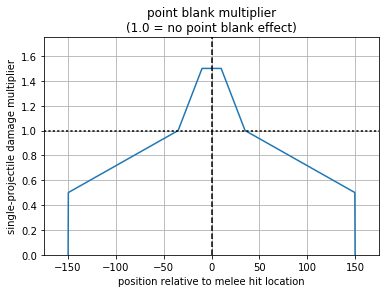

In [8]:
# Let's look at a slice of the point blank stencil
# that crosses the melee hit location.

if window_radius < max_proj_dist:
    print ("WARNING: this graph is truncated along the x axis "
           "because window_radius < max_proj_dist")

pylab.figure()
pylab.plot(x, point_blank_str[(len(x)+1)/2])
pylab.title('point blank multiplier\n(1.0 = no point blank effect)')
pylab.ylabel('single-projectile damage multiplier')
pylab.xlabel('position relative to melee hit location')
pylab.plot([-175, 175], [1, 1], 'k:')
pylab.plot([0, 0], [0, 1.75], 'k--')
pylab.grid(True)
pylab.axis([-175, 175, 0, 1.75]);

from mpl_toolkits.mplot3d.axes3d import Axes3D
pylab.figure(figsize=(12, 3))
ax = pylab.gcf().add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(xx, yy, point_blank_str)
#ax.contour(xx, yy, point_blank_str, zdir='z', offset=-0.1, cmap=pylab.cm.coolwarm)
#ax.set_zlim3d(-0.1, 1.5);

# Ball AoE Shape and Hitboxes

Here we create a stencil that shows how the molten strike balls spread out,
based on the AoE modifiers.

This does not account for the number of balls or any point blank effects.
We'll handle those later.

Since these effects depend on the user configuration choices, the 3rd dimension
represents the index into the pandas dataframe.  That dataframe has one row
per user configuration.

## Analytic + Numeric Solution

Here we analytically derive the AoE shape, hitboxes, etc. and
sample them to a grid for further visualization and analysis.
Analytical = using formulas.

In [9]:
# This is a circular boolean stencil that tells whether a ball
# landing at a given location would be counted as a hit against
# a boss.
ms_can_hit = r[:, :, None] <= configs2['max_hit_dist'][None, None, :]

# This is a boolean stencil that gives the 270 degree arc where
# the molten strike balls can land.
ms_ball_coverage = (
    (r[:, :, None] >= configs2['inner_rad'][None, None, :]) &
    (r[:, :, None] <= configs2['outer_rad'][None, None, :]) &
    (np.abs(np.arctan2(yy, xx) * 360 / (2 * np.pi)) < arc_degrees / 2)[:, :, None]
)

# This is the probability of a ball hitting a particular point within
# the stencil.  See https://redd.it/568ew3 for details.
ms_ball_hit_frac = (
    ms_ball_coverage /
    # np.maximum is to deal with a blowup at the origin.  The correct
    # way is to realize that we should be integrating over our sample
    # pixels rather than taking point samples, but that's more work
    # and the approximation error inside the hit maks is tiny since
    # it has a min radius of 5 units.
    np.maximum(1e-9, r[:, :, None])
)
ms_ball_hit_frac /= ms_ball_hit_frac.sum(axis=1).sum(axis=0) # normalize it to a probability distribution

# This tells what fraction of the molten strike balls will hit the
# boss on average, if the boss is centered at the melee strike location.
ms_centered_boss_hit_frac = (
    np.asarray(ms_can_hit * ms_ball_hit_frac, dtype='float64').sum(axis=1).sum(axis=0)
)

# Now we scale it up by the number of balls per attack.
avg_ball_hit_count_if_boss_centered = ms_centered_boss_hit_frac * configs2['num_projs']
configs2['avg_ball_hit_count_if_boss_centered'] = avg_ball_hit_count_if_boss_centered

In [10]:
# Let's visualize what's going on here to make it easier
# to understand.

example_ix = 7 # Pick your favorite dataframe index to look at.

i1 = (window_radius - 32) * super_sample_factor
i2 = (window_radius + 32) * super_sample_factor + 1
pylab.imshow(
    np.asarray(
        [
            # Red channel = if a ball lands here, it'll hit the boss.
            ms_can_hit[:, :, example_ix] / 2.,
            # Green channel = unused
            np.zeros_like(ms_can_hit[:, :, example_ix]),
            # Blue channel = chance of a ball landing on a particular location
            ms_ball_hit_frac[:, :, example_ix] / ms_ball_hit_frac[:, :, example_ix].max()
        ],
        dtype='float'
    ).T[i1:i2, i1:i2, :]
)
pylab.xticks(np.arange(0, i2-i1, super_sample_factor * 10),
             np.round(x[i1:i2:super_sample_factor*10]).astype('int'))
pylab.yticks(np.arange(0, i2-i1, super_sample_factor * 10),
             np.round(y[i1:i2:super_sample_factor*10]).astype('int'))
print 'blue and magenta = arc where balls land'
print 'red and magenta  = where balls must land to hit boss, if boss is at center'
print 'magenta          = hits'
print
print 'Example Configuration Used for this Figure:'
print configs2.ix[example_ix]

blue and magenta = arc where balls land
red and magenta  = where balls must land to hit boss, if boss is at center
magenta          = hits

Example Configuration Used for this Figure:
has_helm_enchant                          True
conc_gem                                  True
aoe_gem                                  False
num_wildfire                                 2
tree_aoe                                     0
dying_sun                                 True
flask_eff                                    0
point_blank                               True
tree_range                                   2
inner_rad                                    5
outer_rad                              22.3047
ball_rad                               10.1025
max_hit_dist                           13.1025
num_projs                                   12
melee_hit_dist_from_exile                   11
avg_ball_hit_count_if_boss_centered    5.62504
Name: 7, dtype: object


## Simulation

It turns out that simulating ball drop locations is really easy, so
here we esimate the distribution of ball hit locations using simulated
attacks.  We then compare this distribution to what we computed
analytically to verify that that analytic solution is working
correctly.

RMS error: 0.00606581032168


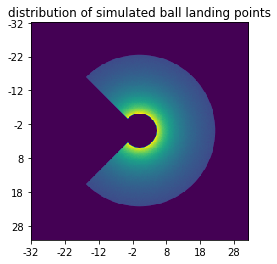

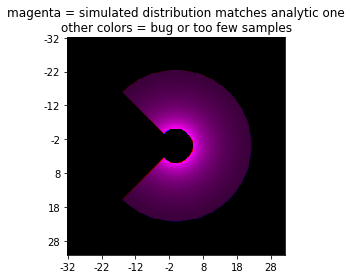

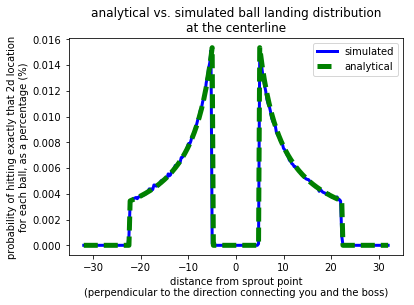

In [11]:
# Now let's verify that simulating a bunch of ball hits
# gives the same answer as our analytic solution.

# Use 100 million samples so we don't have to worry about smoothing
# and other such stuff when comparing against the analytic mask.
N = 100 * 1000 * 1000

# Randomly sample points uniformly via radius and angle (not area).
radius_samples = (np.random.random(N) * (configs2.outer_rad.ix[example_ix] -
                                         configs2.inner_rad.ix[example_ix]) +
                  configs2.inner_rad.ix[example_ix])
angle_samples  = (np.random.random(N) * arc_degrees - arc_degrees/2) * 2 * np.pi / 360

# Gather the samples to create a 2d distribution.
#
# This is slow if you have a lot of samples.
x_samples    = radius_samples * np.cos(angle_samples)
y_samples    = radius_samples * np.sin(angle_samples)
sample_votes = np.histogram2d(x_samples, y_samples,
                              bins=(np.r_[x, x[-1]*2+1],
                                    np.r_[y, y[-1]*2+1]))[0]
sim_ms_ball_hit_frac = (sample_votes / np.max(sample_votes))

rms_err = (
    np.sqrt(
        np.mean(
            (
                sim_ms_ball_hit_frac -
                ms_ball_hit_frac[:, :, example_ix] / ms_ball_hit_frac[:, :, example_ix].max()
            ) ** 2
        )
    )
)
print 'RMS error:', rms_err

# Show the sample distribution in isolation
pylab.figure()
pylab.imshow(sim_ms_ball_hit_frac.T[i1:i2, i1:i2])
pylab.xticks(np.arange(0, i2-i1, super_sample_factor * 10),
             np.round(x[i1:i2:super_sample_factor*10]).astype('int'))
pylab.yticks(np.arange(0, i2-i1, super_sample_factor * 10),
             np.round(y[i1:i2:super_sample_factor*10]).astype('int'))
pylab.title('distribution of simulated ball landing points')

# Overlay the analytic distribution onto a separate color
# channel.  Red + blue = magenta, so if we did things correctly,
# everything here should be black or magenta.  Other colors mean
# that either we made a mistake or we didn't use enough samples
# to properly simulate the distribution.
pylab.figure()
pylab.imshow(
    np.asarray([
        sim_ms_ball_hit_frac,
        np.zeros_like(sim_ms_ball_hit_frac),
        ms_ball_hit_frac[:, :, example_ix] / ms_ball_hit_frac[:, :, example_ix].max()
    ]).T[i1:i2, i1:i2, :]
)
pylab.xticks(np.arange(0, i2-i1, super_sample_factor * 10),
             np.round(x[i1:i2:super_sample_factor*10]).astype('int'))
pylab.yticks(np.arange(0, i2-i1, super_sample_factor * 10),
             np.round(y[i1:i2:super_sample_factor*10]).astype('int'))
pylab.title('magenta = simulated distribution matches analytic one\n'
            'other colors = bug or too few samples')

# Draw just one slice of the two distributions to make it
# easier to see what's going on here.
pylab.figure()
center_idx = len(x) // 2
pylab.plot(y[i1:i2],
           100 * sim_ms_ball_hit_frac[center_idx, i1:i2] / sim_ms_ball_hit_frac.sum(),
           'b-', linewidth=3,
           label='simulated') 
pylab.plot(y[i1:i2],
           100 * (ms_ball_hit_frac[center_idx, i1:i2, example_ix] /
                  ms_ball_hit_frac[:, :, example_ix].sum()),
           'g--', linewidth=5,
           label='analytical')
pylab.legend()
pylab.title('analytical vs. simulated ball landing distribution\n'
            'at the centerline')
pylab.xlabel('distance from sprout point\n'
             '(perpendicular to the direction connecting you and the boss)')
pylab.ylabel('probability of hitting exactly that 2d location\n'
             'for each ball, as a percentage (%)')

# DPS Multiplier with Boss Centered at Melee Hit

If you're namelocked to the boss, we assume that the melee hit is
centered on the boss.  Here we'll calculate the final DPS multiplier,
factoring in hitboxes, the number of projectiles, point blank, etc.
Multiply the Path of Building's "Total DPS" by the numbers we compute
here.

In [12]:
# Here we turn the hit arc into a point blank adjusted
# multiplier stencil, for each configuration.
#
# This doesn't take into account hitboxes. 
pb_masked_str = (
    (
        # Apply the point blank multipliers for configurations
        # that use it.
        configs.point_blank[None, None, :] *
        point_blank_str[:, :, None] *
        ms_can_hit
    ) +
    (
        # No point blank bonus or penalty for configurations
        # where it's disabled.
        (1 - configs.point_blank[None, None, :]) *
        ms_can_hit
    )
)

# Now factor in hitbox effects and the number of projectiles.
centered_mult = (
    configs2['num_projs'] *
    (pb_masked_str * ms_ball_hit_frac).sum(axis=1).sum(axis=0)
)
configs2['total_dps_multiplier_for_pob_if_centered_boss'] = centered_mult
configs['total_dps_multiplier_for_pob_if_centered_boss'] = centered_mult
configs

   has_helm_enchant conc_gem aoe_gem  num_wildfire  tree_aoe dying_sun  \
0             False    False   False             2      0.00     False   
1             False     True   False             2      0.00     False   
2              True    False   False             2      0.00     False   
3              True    False   False             2      0.00      True   
4              True    False    True             2      0.00      True   
5              True    False    True             2      0.00      True   
6              True     True   False             2      0.00     False   
7              True     True   False             2      0.00      True   
8              True     True   False             2      0.28     False   
9              True     True   False             2      0.28      True   
10             True     True   False             2      0.00      True   
11             True     True   False             2      0.00      True   
12             True     True   False  

# Optimal Boss Location Relative to Melee Hit Location

*Be aware that almost everyone should namelock bosses, unless your
per-projectile DPS is significantly higher than your melee DPS.
This section analyzes the tradeoffs for the test configurations
used throughout this notebook.*

From the perspective of the projectiles, it turns out it's generally
not actually optimal to center the melee hit on the boss.  This is
because most of the boss' hitbox will sit in the middle of the notch
carved out of molten strike's arc.

If we ignore the DPS we're losing from not making melee hits, we
can figure out the optimal offset from the boss to maximize just
the projectile damage.  We'll revisit the loss of melee hits at
the end of this section.

Warning: this can take a while to compute if you chose a large
`super_sample_factor`.

In [13]:
# This computes the final multiplier for every possible x, y offset of
# the boss' center relative to the melee hit location.
mults = (
    np.asarray([
        fftconvolve(
            # Expected number of balls landing on each pixel.
            # Hint: this is a bunch of small numbers.
            (
                np.asarray(ms_ball_hit_frac[:-1, :, i], dtype='float64')  *
                configs2['num_projs'][i]
            ),
            # Convolved with the masked damage kernels.
            pb_masked_str[:, :, i],
            mode='same'
        )
        # We want a set of independent 2d convolutions,
        # not a 3d convolution.
        for i in xrange(len(configs2))
    ])
)

It's fairly easy to see that the optimal location will be along the
line that cuts the arc in half.

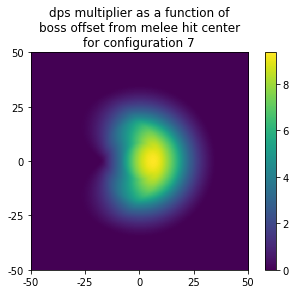

In [14]:
N = mults.shape[1]

example_cfg_idx = 7  # change this to whatever config index you want to look at.

pylab.imshow(mults[example_cfg_idx, :, :].T)
pylab.colorbar()
pylab.title('dps multiplier as a function of\n'
            'boss offset from melee hit center\n'
            'for configuration %d' % (example_cfg_idx,))
pylab.xticks(np.arange(0, N, super_sample_factor * 25),
             np.round(x[0:N:super_sample_factor*25]).astype('int'))
pylab.yticks(np.arange(0, N, super_sample_factor * 25),
             np.round(y[0:N:super_sample_factor*25]).astype('int'))
pylab.axis(np.asarray([-50, 50, -50, 50]) * super_sample_factor +
           window_radius * super_sample_factor)
None

Below, we can see that there's around a 10% *projectile* DPS boost
from standing a little ways back from the boss and shift-attacking.

In [15]:
# Find the optimal diagonal offsets for each configuration.
iy        = (N+1)/2
best_ix   = np.argmax(mults[:, np.arange(N), iy], axis=1)
best_dist = r[best_ix, iy]
best_mult = mults[np.arange(mults.shape[0]), best_ix, iy]

configs2['optimal_boss_to_melee_hit_dist'] = best_dist
configs2['optimal_boss_to_exile_dist'] = configs['optimal_boss_to_exile_dist'] = (
    best_dist + configs2.melee_hit_dist_from_exile)
configs2['total_dps_mult_at_optimal_dist'] = configs['total_dps_mult_at_optimal_dist'] = best_mult

# Visualize it.
pylab.figure(figsize=(8, 4))
i1 = (window_radius - 20) * super_sample_factor
i2 = (window_radius + 36) * super_sample_factor + 1
ii = np.arange(i1, i2)
H  = mults.max()*1.2
for cfg_idx in xrange(mults.shape[0]):
    pylab.plot(x[ii], mults[cfg_idx, ii, iy].T, label='cfg %d' % (cfg_idx,))
pylab.plot([0, 0], [0, H], 'k--', label='if boss is at the melee hit location')
pylab.plot(best_dist, best_mult, 'kx', label='optimal offsets foreach config')
pylab.xlim(x[ii[0]], x[ii[-1]])
pylab.ylim(0, H)
pylab.xlabel('boss location - melee hit location')
pylab.ylabel('total dps multiplier')
pylab.title('How the Melee Hit Location Affects DPS\n'
            'for each of the Configurations')
pylab.legend(bbox_to_anchor=(1,1));

Now let's pick the highest DPS configuration and visualize where the
optimal melee hit location is, but only paying attention to
projectile DPS and ignoring melee DPS.

green plus sign  = your location
gray plus sign   = melee hit location
white plus sign  = boss location

blue and magenta = arc where balls land
red and magenta  = where balls must land to hit boss, at optimal offset
magenta          = hits

Example Configuration Used for this Figure:
has_helm_enchant                                       True
conc_gem                                               True
aoe_gem                                               False
num_wildfire                                              2
tree_aoe                                                  0
dying_sun                                              True
flask_eff                                               0.5
point_blank                                            True
tree_range                                                2
inner_rad                                                 5
outer_rad                                           23.1706
ball_rad                                             1

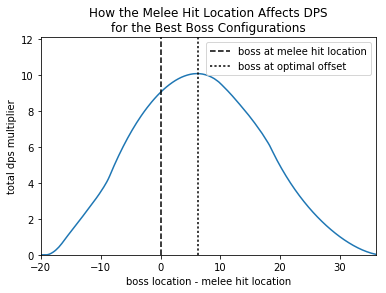

In [30]:
# Let's find the single best configuration.
#
# If you want to see a particular other configuration,
# just hard code this to be the index you want from the
# configuration dataframe.
best_cfg_idx = np.unravel_index(np.argmax(mults), mults.shape)[0]

# Let's find it's best offset along the centerline.
best_ix = np.argmax(mults[best_cfg_idx, np.arange(N), iy])
best_x  = x[best_ix]

# Now let's draw a schematic of it.
i1 = (window_radius - 30) * super_sample_factor
i2 = (window_radius + 30) * super_sample_factor + 1
pylab.imshow(
    np.asarray(
        [
            shift(
                ms_can_hit[:, :, best_cfg_idx],
                [best_x * super_sample_factor, 1],
                order=0, prefilter=False
            ),
            np.zeros_like(ms_can_hit[:, :, best_cfg_idx]),
            ms_ball_hit_frac[:, :, best_cfg_idx] > 0,
        ],
        dtype='float64'
    ).T[i1:i2, i1:i2, :]
)

def draw_plus(p1, color):
    p0 = p1 - 3 * super_sample_factor
    p2 = p1 + 3 * super_sample_factor
    pylab.plot([p1, p1],
               [iy - 3 * super_sample_factor - i1,
                iy + 3 * super_sample_factor - i1],
               color=color, linewidth=5)
    pylab.plot([p0, p2],
               [iy - i1]*2, 
               color=color, linewidth=5)
    
tot_mace_range = configs2.melee_hit_dist_from_exile[best_cfg_idx]

draw_plus( best_x         * super_sample_factor + (i2 - i1) / 2, 'w')
draw_plus(-tot_mace_range * super_sample_factor + (i2 - i1) / 2, 'g')
draw_plus((i2 - i1) / 2, [.2, .2, .2])

pylab.xticks(np.arange(0, i2-i1, super_sample_factor * 10),
             np.round(x[i1:i2:super_sample_factor*10]).astype('int'))
pylab.yticks(np.arange(0, i2-i1, super_sample_factor * 10),
             np.round(y[i1:i2:super_sample_factor*10]).astype('int'))

# Now let's plot the distance curve for just this configuration.
pylab.figure()
pylab.plot(x[ii], mults[best_cfg_idx, ii, iy].T)
pylab.plot([0, 0], [0, H], 'k--', label='boss at melee hit location')
pylab.plot([best_x]*2, [0, H], 'k:',  label='boss at optimal offset')
pylab.xlim(x[ii[0]], x[ii[-1]])
pylab.ylim(0, H)
pylab.xlabel('boss location - melee hit location')
pylab.ylabel('total dps multiplier')
pylab.title('How the Melee Hit Location Affects DPS\n'
            'for the Best Boss Configurations')
pylab.legend();

# Give some extra info to users.
print 'green plus sign  = your location'
print 'gray plus sign   = melee hit location'
print 'white plus sign  = boss location'
print
print 'blue and magenta = arc where balls land'
print 'red and magenta  = where balls must land to hit boss, at optimal offset'
print 'magenta          = hits'
print
print 'Example Configuration Used for this Figure:'
print configs2.ix[best_cfg_idx]

Now, let's compute the effective bonus we get from optimal placement of
our melee hit given it will cause us to lose the melee hit's damage.  For
simplicity, we'll assume the melee hit has slightly more damage than one
projectile, prior to point blank effects.  We'll also assume that all
the "optimal" offsets are far enough away that we'll miss the melee hit.

In [17]:
pob_melee_hit_total_dps = 558100
pob_proj_hit_total_dps  = 547141
melee_hit_to_proj_hit_dmg_ratio = pob_melee_hit_total_dps / pob_proj_hit_total_dps

net_bonus_mult = (
    configs2['total_dps_mult_at_optimal_dist'] /
    (
        # if centered, average damage from projectiles, accounting
        # for everything
        configs2['total_dps_multiplier_for_pob_if_centered_boss'] +
        # plus one melee hit, at the same scale as the dps multiplier
        melee_hit_to_proj_hit_dmg_ratio
    )
)

configs2['more_dps_from_optimal_placement'] = configs['more_dps_from_optimal_placement'] = net_bonus_mult - 1

# Final Results with Optimal Melee Hit Placement

Here are the final results.  Unless your per-projectile DPS is substantially
higher than your melee DPS, you'll find that you get 0-4% more total DPS
by namelocking.  Also, it's mechanically far easier to namelock than to try
to fine-tune your distance to the boss.

In [18]:
configs

   has_helm_enchant conc_gem aoe_gem  num_wildfire  tree_aoe dying_sun  \
0             False    False   False             2      0.00     False   
1             False     True   False             2      0.00     False   
2              True    False   False             2      0.00     False   
3              True    False   False             2      0.00      True   
4              True    False    True             2      0.00      True   
5              True    False    True             2      0.00      True   
6              True     True   False             2      0.00     False   
7              True     True   False             2      0.00      True   
8              True     True   False             2      0.28     False   
9              True     True   False             2      0.28      True   
10             True     True   False             2      0.00      True   
11             True     True   False             2      0.00      True   
12             True     True   False  

In [19]:
configs2.ix[[7]].T

                                                        7
has_helm_enchant                                     True
conc_gem                                             True
aoe_gem                                             False
num_wildfire                                            2
tree_aoe                                                0
dying_sun                                            True
flask_eff                                               0
point_blank                                          True
tree_range                                              2
inner_rad                                               5
outer_rad                                         22.3047
ball_rad                                          10.1025
max_hit_dist                                      13.1025
num_projs                                              12
melee_hit_dist_from_exile                              11
avg_ball_hit_count_if_boss_centered               5.62504
total_dps_mult

In [20]:
configs2.ix[[7,9]].T

                                                        7           9
has_helm_enchant                                     True        True
conc_gem                                             True        True
aoe_gem                                             False       False
num_wildfire                                            2           2
tree_aoe                                                0        0.28
dying_sun                                            True        True
flask_eff                                               0           0
point_blank                                          True        True
tree_range                                              2           2
inner_rad                                               5           5
outer_rad                                         22.3047     23.8956
ball_rad                                          10.1025     10.8598
max_hit_dist                                      13.1025     13.8598
num_projs           

In [21]:
# Save results to a file.  This makes it easier to upload them
# to Google Sheets, etc.
configs2.to_csv('molten_dps.csv')

# I've uploaded a cleaned up version of this spreedsheet to:
#
# https://docs.google.com/spreadsheets/d/1Q2xheoBXr07DVpN_jPFKQy8ILt0KgYpGoDVI8LSTdyo/edit?usp=sharing

# Future Work

It would be nice to actually factor in the melee hit and see what
happens if we're barely in range to connect with that hit.  For such
an analysis, it would be important to know whether the balls sprout
from the melee hit location of the boss' center if the melee hit
barely touches the outer rim of the boss' hitbox.

Technically, we should do the calculations assuming square mobs and
projectiles instead of circular ones.  A reasonable approximation
might be to compute the average Euclidean radius of a square and
adjust the ball and boss radii by this factor.

There are several images rendered with `pylab.imshow` in this notebook
but they don't seem to show up in GitLab.  It would be nice to figure
out a way to fix this without doing something crazy like rendering each
pixel as a patch.